## Imports

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import InceptionV3
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

## Load Dataset

In [2]:
# Load the Dogs vs. Cats dataset
train_dataset, info = tfds.load('cats_vs_dogs', split='train[:80%]', with_info=True , as_supervised=True)
test_dataset = tfds.load('cats_vs_dogs', split='train[80%:]', with_info=False , as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteLK98JY/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [3]:
IMAGE_SIZE = (128, 128)

#Extract train data
train_images = []
train_labels = []
for image, label in train_dataset:
    train_images.append(tf.image.resize(image, IMAGE_SIZE))
    train_labels.append(label)

In [4]:
#Extract test data
test_images = []
test_labels = []
for image, label in test_dataset:
    test_images.append(tf.image.resize(image, IMAGE_SIZE))
    test_labels.append(label)

In [5]:
# Convert lists to TensorFlow tensors
train_images = tf.stack(train_images)
train_labels = tf.stack(train_labels)
test_images = tf.stack(test_images)
test_labels = tf.stack(test_labels)

In [6]:
# Convert labels to float32
train_labels = tf.cast(train_labels, tf.float32)
test_labels = tf.cast(test_labels, tf.float32)

## Preprocess

In [7]:
# Define batch size
BATCHSIZE = 32

# Create an instance of ImageDataGenerator
datagen = ImageDataGenerator(
    rescale = 1./255, # Rescale pixel values to [0, 1]
    rotation_range=40,  # Random rotation up to 40 degrees
    width_shift_range=0.2,  # Randomly shift width up to 20% of the image width
    height_shift_range=0.2,  # Randomly shift height up to 20% of the image height
    zoom_range=0.2,  # Random zoom in the range [0.8, 1.2]
    horizontal_flip=True,  # Randomly flip inputs horizontally
)

# Prepare training data generator
train_generator = datagen.flow(train_images , train_labels , batch_size = BATCHSIZE , shuffle = True)

# Prepare testing data generator (without augmentation)
test_generator = ImageDataGenerator(rescale=1./255).flow(test_images , test_labels , batch_size=BATCHSIZE)

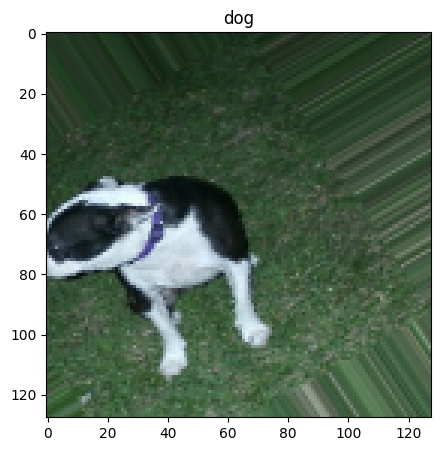

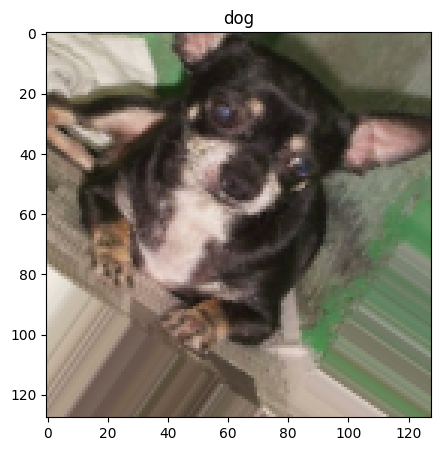

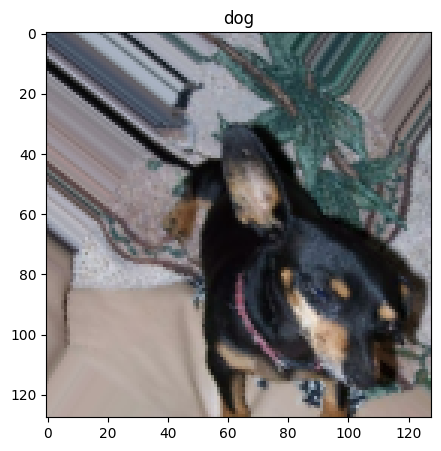

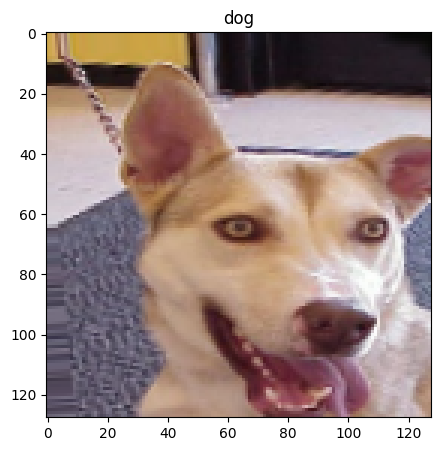

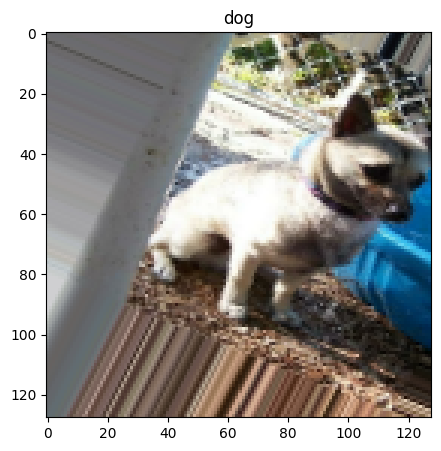

In [8]:
##show some of images with their labels
for image in range(5):
  plt.figure(figsize=(5, 5))
  plt.imshow(train_generator[0][0][image])
  if train_generator[0][1][image] == 0:
    plt.title('cat')
  else:
    plt.title('dog')
  plt.show()

## Load and change the model

In [9]:
# Load the Inception-v3 model
inception_model =InceptionV3(weights='imagenet', include_top=False, input_shape=(128 ,128, 3) , classes=2)
print(inception_model.summary())

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 63, 63, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 63, 63, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

In [10]:
#create your model
x = layers.Flatten()(inception_model.output)
ypredict = layers.Dense(1 , activation='sigmoid')(x)

model = Model(inputs=inception_model.input , outputs=ypredict)
#dont forget to freeze the pretrained part
for layer in inception_model.layers:
  layer.trainable = False

In [11]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy' , tf.keras.metrics.F1Score()])

# Print model summary
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 63, 63, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 63, 63, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 63, 63, 32)           0         ['batch_normalization[0][0

In [13]:
#train your model
epochs = 10

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
)

Epoch 1/10
582/582 [==============================] - 90s 154ms/step - loss: 0.4049 - accuracy: 0.8812 - f1_score: 0.6743 - val_loss: 0.2218 - val_accuracy: 0.9390 - val_f1_score: 0.6903
Epoch 2/10
582/582 [==============================] - 90s 155ms/step - loss: 0.4394 - accuracy: 0.8821 - f1_score: 0.6770 - val_loss: 0.2245 - val_accuracy: 0.9377 - val_f1_score: 0.6871
Epoch 3/10
582/582 [==============================] - 88s 152ms/step - loss: 0.3981 - accuracy: 0.8877 - f1_score: 0.6733 - val_loss: 0.2265 - val_accuracy: 0.9390 - val_f1_score: 0.6917
Epoch 4/10
582/582 [==============================] - 91s 156ms/step - loss: 0.4754 - accuracy: 0.8834 - f1_score: 0.6934 - val_loss: 0.2572 - val_accuracy: 0.9387 - val_f1_score: 0.7228
Epoch 5/10
582/582 [==============================] - 89s 153ms/step - loss: 0.4340 - accuracy: 0.8826 - f1_score: 0.6827 - val_loss: 0.3204 - val_accuracy: 0.9342 - val_f1_score: 0.7210
Epoch 6/10
582/582 [==============================] - 90s 155ms/s

In [14]:
#report the accuracy on your test set
model.evaluate(test_generator)

146/146 [==============================] - 4s 28ms/step - loss: 0.2658 - accuracy: 0.9374 - f1_score: 0.7245


[0.265769362449646, 0.9374462366104126, array([0.724496], dtype=float32)]